In [0]:
#Importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [0]:
##Load the file from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

path = "/content/drive/My Drive/IMDB_Dataset.csv"
IMDB_data = pd.read_csv(path)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Checking the Structure of data
IMDB_data.head()
IMDB_data.shape
IMDB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [0]:
#Encoding the sentiment to 0 and 1 where 0 corresponds to negative review and 1 is positive review
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
IMDB_data['sentiment'] = label_encoder.fit_transform(IMDB_data['sentiment'])
IMDB_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [0]:
#Defining the function for cleaning text
import re
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text

In [0]:
#Separating dependent and target variable 
X = IMDB_data.review.apply(cleanText)       #applying cleanText function
y = IMDB_data.sentiment

In [0]:
# spliting data into training and testing sets ; later we will split the training data further into train and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (40000,), 
Test dataset shape: (10000,)


In [0]:
#Spliting text into words using tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
max_features = 10000
max_len = 500
tok = Tokenizer(num_words=max_features)
#Creating sequences in training data
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)

In [0]:
#Padding sequences in training data
X_train = sequence.pad_sequences(train_sequences, maxlen=max_len)
X_train.shape

(40000, 500)

In [0]:
##Creating and padding sequences in the test data
test_sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(test_sequences, maxlen=max_len)
X_test.shape

(10000, 500)

In [0]:
#Simple RNN model

model = tf.keras.Sequential()

embedding_size=128
model.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))
model.add(layers.SimpleRNN(64, activation='tanh'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,292,417
Trainable params: 1,292,417
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [0]:
#Validation split = 0.375 divides the training samples(40000) into 25000 and 15000 for training and validation samples
history = model.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 107s 429ms/step - loss: 0.6372 - accuracy: 0.6071 - val_loss: 0.5854 - val_accuracy: 0.6779
Epoch 2/10
250/250 [==============================] - 107s 429ms/step - loss: 0.3837 - accuracy: 0.8334 - val_loss: 0.4303 - val_accuracy: 0.8131
Epoch 3/10
250/250 [==============================] - 107s 427ms/step - loss: 0.1419 - accuracy: 0.9504 - val_loss: 0.5227 - val_accuracy: 0.8091


In [0]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 15s 47ms/step - loss: 0.5100 - accuracy: 0.8142
Test loss: 0.5099834203720093
Test accuracy: 0.8141999840736389


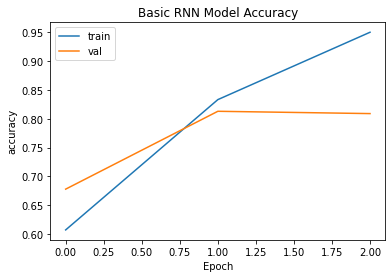

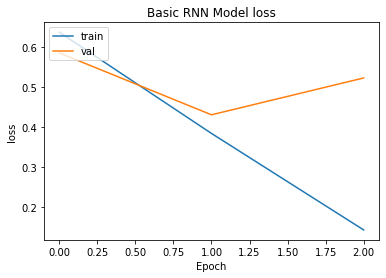

In [0]:
#Plotting the training and validation accuracy 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Basic RNN Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Basic RNN Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [0]:
##LSTM model

from tensorflow.keras import layers
model1 = tf.keras.Sequential()

embedding_size=128
model1.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))

model1.add(layers.LSTM(64))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dropout(0.2))

model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [0]:
model1.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
history = model1.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 41s 164ms/step - loss: 0.4779 - accuracy: 0.7774 - val_loss: 0.3185 - val_accuracy: 0.8712
Epoch 2/10
250/250 [==============================] - 39s 158ms/step - loss: 0.2623 - accuracy: 0.9025 - val_loss: 0.3012 - val_accuracy: 0.8796
Epoch 3/10
250/250 [==============================] - 37s 149ms/step - loss: 0.1864 - accuracy: 0.9324 - val_loss: 0.3186 - val_accuracy: 0.8821


In [0]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 10s 33ms/step - loss: 0.3062 - accuracy: 0.8837
Test loss: 0.3062107264995575
Test accuracy: 0.8837000131607056


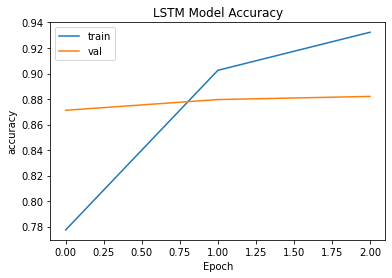

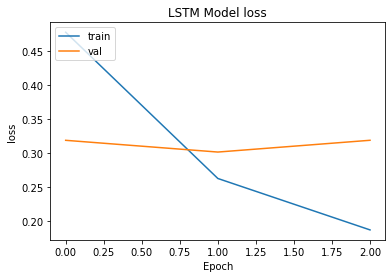

In [0]:
#Plotting the training and validation accuracy 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [0]:
##Multi-layered LSTM 

from tensorflow.keras import layers
model2 = tf.keras.Sequential()

embedding_size=128
model2.add(Embedding(max_features,
                    embedding_size,
                    input_length=max_len))

model2.add(layers.LSTM(64,return_sequences=True))
model2.add(layers.LSTM(32))

model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dropout(0.2))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

In [0]:
model2.compile(loss= 'binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [0]:
history = model2.fit(X_train, y_train, epochs=10,batch_size=100, validation_split=0.375,
                    callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Epoch 1/10
250/250 [==============================] - 72s 288ms/step - loss: 0.4778 - accuracy: 0.7794 - val_loss: 0.3153 - val_accuracy: 0.8697
Epoch 2/10
250/250 [==============================] - 72s 287ms/step - loss: 0.2741 - accuracy: 0.9001 - val_loss: 0.2995 - val_accuracy: 0.8783
Epoch 3/10
250/250 [==============================] - 72s 287ms/step - loss: 0.2000 - accuracy: 0.9319 - val_loss: 0.3597 - val_accuracy: 0.8799


In [0]:
# Next, compare how the model performs on the test dataset:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 21s 68ms/step - loss: 0.3445 - accuracy: 0.8829
Test loss: 0.34452611207962036
Test accuracy: 0.8828999996185303


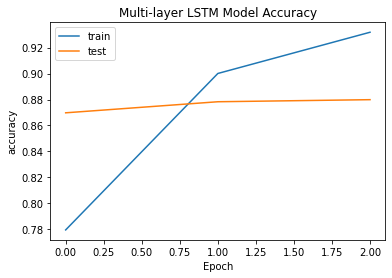

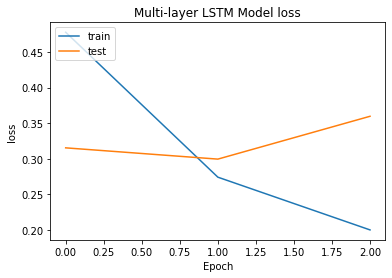

In [0]:
#Plotting the training and validation accuracy 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Multi-layer LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Multi-layer LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()